In [140]:
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pysam
from IPython.display import display

plt.style.use('ggplot')

In [178]:
def indel_distribution(filepath, title='', folder='HW3_data/'):
    with pysam.AlignmentFile(folder + filepath, 'r') as pb:
        indel_size = defaultdict(int)
        cigar_operations = 'MIDNSHP=XB'
        for read in pb.fetch():
            if read.cigartuples:
                for i, size in read.cigartuples:
                    if cigar_operations[i] in ('ID'):
                        indel_size[size] += 1
        fig, ax = plt.subplots(figsize=(8, 6))

        sorted_indels = list(indel_size.items())
        x = [item[0] for item in sorted_indels]
        y = [item[1] for item in sorted_indels]
        ax.yaxis.label.set_text('ln freq')
        ax.bar(x, np.log(y), snap=False)
        ax.set_xlim((-10, 600))
        plot_title = 'Indel size distribution'
        if title:
            plot_title += ' - ' + title
        ax.set_title(plot_title)
        fig.tight_layout()
        
        
def coverage(filepath, folder='HW3_data/', title='', plotsize=5000):

    with pysam.AlignmentFile(folder + filepath, 'r') as pb:
        ref_length = pb.lengths[0]
        perbase_cov = np.zeros(ref_length)
        for column in pb.pileup():
            perbase_cov[column.pos] = column.n
    print(f'Mean coverage: {round(np.mean(perbase_cov), 2)}')
    print(f'{round(np.mean(perbase_cov != 0) * 100, 2)} % covered')

    fig, ax = plt.subplots(figsize=(10, 8))
    averaged_cov = np.array([np.mean(chunk) for chunk in np.array_split(perbase_cov, plotsize)])
    positions = np.arange(1, ref_length+1, ref_length // plotsize)
    positions = np.array([chunk[0] for chunk in np.array_split(np.arange(1, ref_length), plotsize)])
    sns.lineplot(x=positions, y=averaged_cov, ax=ax)
    ax.set_xlabel('Genome position')
    ax.set_ylabel('Coverage')
    plot_title = 'Coverage'
    if title:
        plot_title += ' - ' + title
    fig.suptitle(plot_title, fontsize=25)
    fig.tight_layout()   
    
    
def errors(filepath, folder='HW3_data/'):
    cigar_operations = 'MIDNSHP=XB'
   
    error_percentage = np.zeros(100)
    substitutions = {base: {} for base in 'ATGC'}
    for i in 'ATGC':
        for j in 'ATGC':
            substitutions[i][j] = 0
            
    with pysam.AlignmentFile(folder + filepath, 'r') as pb:
        for read in pb.fetch():
            try:
                ref = read.get_reference_sequence()
            except TypeError:
                continue
            
            query = read.query_sequence
            ref_position = 0
            query_position = 0
            error_count = 0
            for i, size in read.cigartuples:
                op = cigar_operations[i]
                if op == 'M':
                    ref_position += size
                    query_position += size
                elif op == 'I':
                    query_position += size
                    error_count += size
                elif op == 'D':
                    ref_position += size
                    error_count += size
                elif op == 'N':
                    ref_position += size
                elif op == 'S':
                    query_position += size
                elif op in 'HP':
                    pass
                elif op == '=':
                    query_position += size
                    ref_position += size
                elif op == 'X':
                    for i in range(size):
                        refb = ref[ref_position + i].upper() 
                        queryb = query[query_position + i].upper()
                        substitutions[refb][queryb] += 1
                    ref_position += size
                    query_position += size
                    error_count += size
                
            read_length = len(read.query_sequence)
            error_percent = round(error_count / read_length * 100)
            error_percentage[error_percent] += 1
    
    # средний процент ошибок в ридах
    total = 0
    n_reads = 0
    for i, count in enumerate(error_percentage):
        n_reads += count
        percent = i + 1
        total += percent * count
    print(f'Mean error percent: {round(total / n_reads, 2)}%')
        
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(np.arange(1, 101), error_percentage, snap=False)
    ax.set_title('Error percent distribution')
    fig.tight_layout()
                
    tmp = pd.DataFrame(substitutions)
    tmp = tmp / tmp.sum().sum()  
    print('Relative substituiton frequencies')
    display(tmp)


### pacbio
```bash
minimap2 -H reference.fasta -d pbindex.idx 
minimap2 pbindex.idx pacbio_40x.fq -a --MD --eqx | samtools view -b | samtools sort > pb_sorted.bam
samtools index pb_sorted.bam
```
### nanopore
```bash
minimap2 reference.fasta -d npindex.idx
minimap2 npindex.idx ONT_2D.fastq -a --MD --eqx | samtools view -b | samtools sort > np_sorted.bam
samtools index np_sorted.bam
```

In [160]:
!samtools flagstat HW3_data/pb_sorted.bam

52242 + 0 in total (QC-passed reads + QC-failed reads)
1701 + 0 secondary
9094 + 0 supplementary
0 + 0 duplicates
51645 + 0 mapped (98.86% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


In [161]:
!samtools flagstat HW3_data/np_sorted.bam

32103 + 0 in total (QC-passed reads + QC-failed reads)
1072 + 0 secondary
221 + 0 supplementary
0 + 0 duplicates
29565 + 0 mapped (92.09% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


##  pacbio_40x.fq

Mean coverage: 40.42
100.0 % covered
Mean error percent: 14.45%
Relative substituiton frequencies


,A,T,G,C
A,0.000000,0.067114,0.075771,0.106527
T,0.067131,0.000000,0.104839,0.075759
G,0.071646,0.083654,0.000000,0.096310
C,0.082426,0.072123,0.096701,0.000000


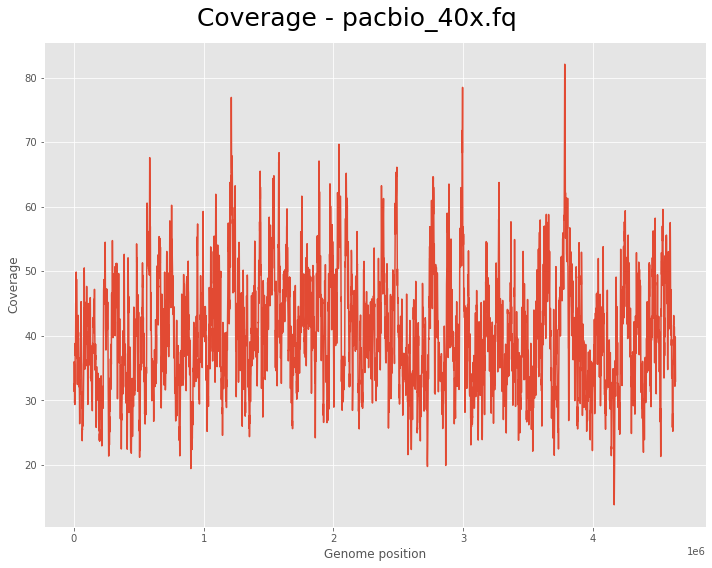

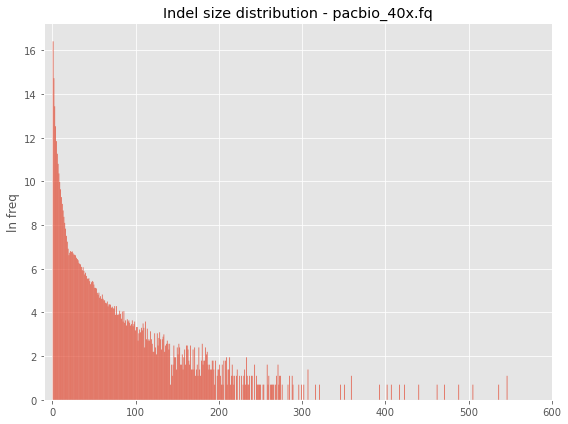

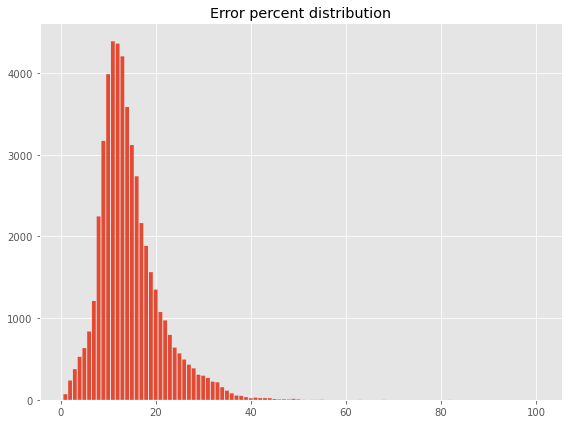

In [179]:
filename = 'pb_sorted.bam'
title = 'pacbio_40x.fq'
coverage(filename, title=title)
indel_distribution(filename, title=title)
errors(filename)

---
---

Mean coverage: 28.01
100.0 % covered
Mean error percent: 9.03%
Relative substituiton frequencies


,A,T,G,C
A,0.000000,0.047283,0.140297,0.060130
T,0.046233,0.000000,0.055497,0.149474
G,0.161676,0.048898,0.000000,0.037306
C,0.049563,0.163560,0.040082,0.000000


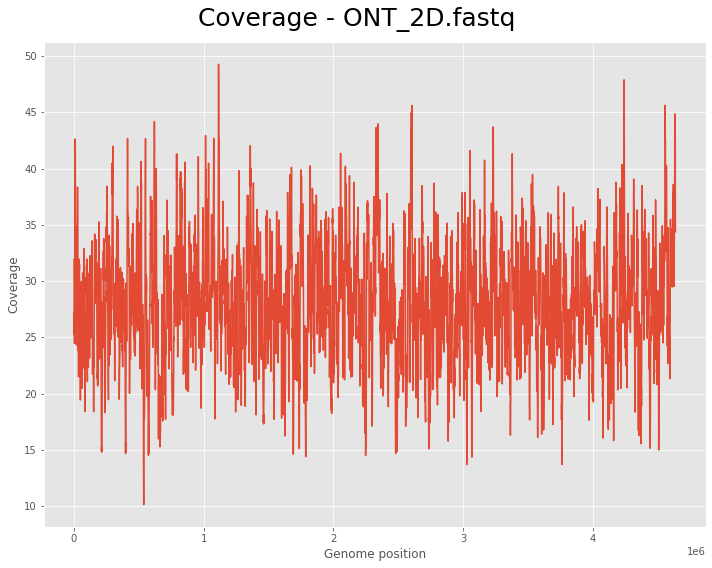

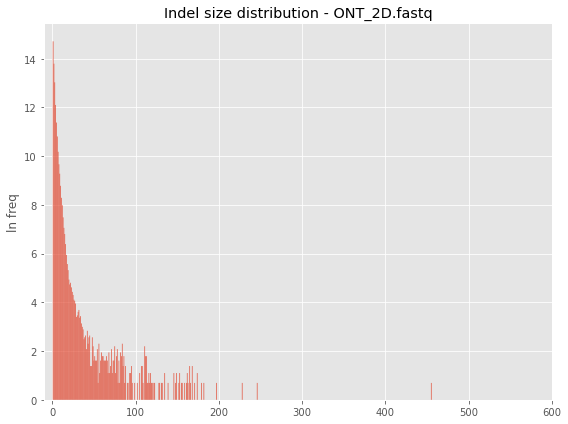

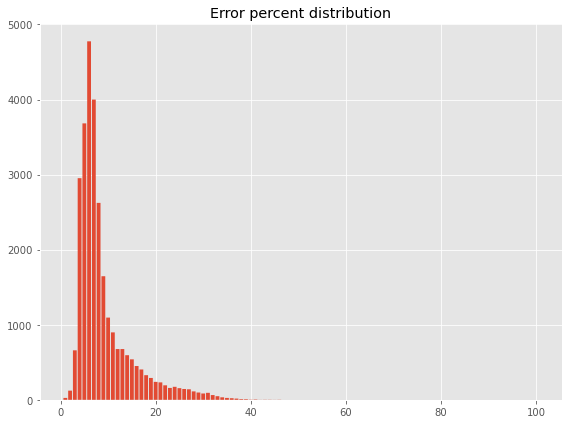

In [180]:
filename = 'np_sorted.bam'
title = 'ONT_2D.fastq'
coverage(filename, title=title)
indel_distribution(filename, title=title)
errors(filename)

У Nanopore больше ошибок.

Распределение длин инделов совпадает.

